In the 'markdown cell' below  replace the `???` with the names of those in your group.

Group 16: Kotha Shruthi, Mei Li, Lingxiao Li

# Assignment (part3): Classification of cell morphological changes with transfer learning
_by Phil Harrison (February 2021)_

Note: only those students who wish to potentially achieve a `VG` grade need do this part of the assignment.

## Load packages

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

# TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input

# Helper libraries
import random
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.utils import class_weight
import pandas as pd
from PIL import Image

from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False
print(tf.__version__)

2.1.0


## Functions
Don't worry too much about the code in the functions below, but you might want to go through when they are called later on so that you roughly understand what they're doing.

In [2]:
def load_dataset():
    dirname = 'bbbc021v1_images'
    x_orig = np.zeros((660, 256, 256, 3), dtype=np.float32)

    for f in range(x_orig.shape[0]):
        img    = Image.open(dirname + '/bbbc021v1_%s.png' % str(f))
        img    = np.array(img)
        x_orig[f] = img

    labels = pd.read_csv('bbbc021v1_labels.csv',
                          usecols=["compound", "concentration", "moa"],
                          sep=";")
    y_orig = np.array(labels['moa'])

    return x_orig, y_orig

def convert_to_one_hot(y, C):
    moa_dict = {'Aurora kinase inhibitors': 0, 'Cholesterol-lowering': 1,
                'Eg5 inhibitors': 2, 'Protein synthesis': 3, 'DNA replication': 4, 'DNA damage': 5}

    y = np.asarray([moa_dict[item] for item in y])
    y = np.eye(C)[y]
    y = y.astype('float32')

    return y

def plot_history(model_history, model_name):
    fig = plt.figure(figsize=(15, 5), facecolor='w')
    ax = fig.add_subplot(131)
    ax.plot(model_history.history['loss'])
    ax.plot(model_history.history['val_loss'])
    ax.set(title=model_name + ': Model loss', ylabel='Loss', xlabel='Epoch')
    ax.legend(['train', 'valid'], loc='upper right')
    
    ax = fig.add_subplot(132)
    ax.plot(np.log(model_history.history['loss']))
    ax.plot(np.log(model_history.history['val_loss']))
    ax.set(title=model_name + ': Log model loss', ylabel='Log loss', xlabel='Epoch')
    ax.legend(['Train', 'Test'], loc='upper right')    

    ax = fig.add_subplot(133)
    ax.plot(model_history.history['accuracy'])
    ax.plot(model_history.history['val_accuracy'])
    ax.set(title=model_name + ': Model accuracy', ylabel='Accuracy', xlabel='Epoch')
    ax.legend(['train', 'valid'], loc='upper right')
    plt.show()
    plt.close()

def plot_confusion_matrix(cm, classes, model_name,
                          cmap=plt.cm.Blues):
    title = model_name + ': Confusion Matrix'
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
def valid_evaluate(model, model_name):
    y_pred = model.predict(X_valid)
    y_pred = y_pred.argmax(axis=-1)
    y_true = Y_valid.argmax(axis=-1)
    
    class_names = ['Aur', 'Ch', 'Eg5', 'PS', 'DR', 'DS']
    cnf_matrix = confusion_matrix(y_true, y_pred)
    np.set_printoptions(precision=2)
    plt.figure(figsize=(15,5), facecolor='w')
    plot_confusion_matrix(cnf_matrix, classes=class_names, model_name=model_name)
    plt.show()
    plt.close()
    
    print('')
    print('classification report for validation data:')
    print(classification_report(y_true, y_pred, digits=3))

## Read in and preprocess the data

In [3]:
X_orig, y_orig = load_dataset()
Y = convert_to_one_hot(y_orig, 6)
X = preprocess_input(X_orig)

n_train = 500

random.seed(5026)
indices = np.arange(len(Y))
random.shuffle(indices)

X_train, X_valid = X[indices[:n_train]], X[indices[n_train:]]
Y_train, Y_valid = Y[indices[:n_train]], Y[indices[n_train:]]

## Transfer learning
TRANSFER LEARNING: "_For transfer learning, large annotated datasets, like ImageNet, can be used to pre‐train state‐of‐the‐art CNNs such as Resnet and Inception. The transferred parameter values—providing good initial values for gradient descent—can be fine‐tuned to fit the target data. Alternatively, the pre‐trained parameters in the initial layers can be frozen—capturing generic image representations—while the parameters in the final layers can be fine‐tuned to the current task. Relative to training from scratch, transfer learning allows the fitting of deeper networks, using fewer task‐specific annotated images, for improved classification performance and generalizability_".

Read this TensorFlow tutorial (https://www.tensorflow.org/tutorials/images/transfer_learning). Some things they do there a little differently than we have, don't worry about those. But modify their code cell where they define the `base_model` appropriate for our case (ie. replace `???` below accordingly) where we will use the ResNet50 pretrained (base) model and chage the image shape appropriately for our data.

In [29]:
IMG_SIZE = (256, 256)
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.ResNet50(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In the code cell below make it such that you don't train the base model (i.e. to start with we freeze the base model and only train the part we've added to the top. Also add a line of code to summarise your base model.

In [25]:
base_model.trainable = False
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_7[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

Your model above should have a whopping 23,587,712 parameters!

In [30]:
num_classes = 6
x = base_model.output
x = layers.GlobalAveragePooling2D()(x) # add a global average pooling layer
preds = layers.Dense(6, activation='softmax')(x) # add your final dense layer with a softmax activation

ResNet50 = models.Model(inputs=base_model.input, outputs=preds)
ResNet50.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_8[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

Your model should now have 23,600,006 parameters.

## Training with the base frozen
In the code cell below compile your `ResNet50` model to use the Adam optimizer (with a learning rate of 0.001), categorical_crossentropy loss and have `accuracy` as a metric to keep track of.

In [31]:
lr = 0.001
ResNet50.compile(optimizer=optimizers.Adam(lr=lr), 
               loss='categorical_crossentropy',
               metrics=['accuracy'])

In the code cell below fit, plot and evaluate your model. Use a batch size of 32 and train your model for 10 epochs. We don't need to train for that long when we are essentially only training the end part of the network that we tacked onto the base model.

Train on 500 samples, validate on 160 samples
Epoch 1/10
500/500 - 16s - loss: 0.5747 - accuracy: 0.8100 - val_loss: 5251.4804 - val_accuracy: 0.2937
Epoch 2/10
500/500 - 3s - loss: 0.2993 - accuracy: 0.9200 - val_loss: 4384.1847 - val_accuracy: 0.2875
Epoch 3/10
500/500 - 4s - loss: 0.4071 - accuracy: 0.9540 - val_loss: 10337.0428 - val_accuracy: 0.3938
Epoch 4/10
500/500 - 3s - loss: 0.2945 - accuracy: 0.9240 - val_loss: 473279.9125 - val_accuracy: 0.1750
Epoch 5/10
500/500 - 4s - loss: 0.1110 - accuracy: 0.9720 - val_loss: 11880.8803 - val_accuracy: 0.1750
Epoch 6/10
500/500 - 3s - loss: 0.2445 - accuracy: 0.9520 - val_loss: 2829.5199 - val_accuracy: 0.2000
Epoch 7/10
500/500 - 4s - loss: 0.0893 - accuracy: 0.9760 - val_loss: 35.0491 - val_accuracy: 0.4688
Epoch 8/10
500/500 - 3s - loss: 0.1069 - accuracy: 0.9740 - val_loss: 84.7878 - val_accuracy: 0.3500
Epoch 9/10
500/500 - 3s - loss: 0.0866 - accuracy: 0.9720 - val_loss: 85.3329 - val_accuracy: 0.2375
Epoch 10/10
500/500 - 3s - l

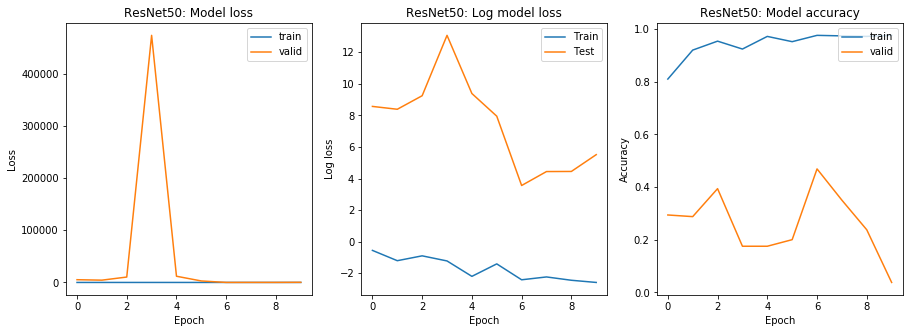

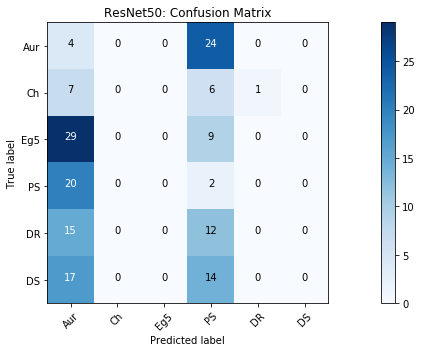


classification report for validation data:
              precision    recall  f1-score   support

           0      0.043     0.143     0.067        28
           1      0.000     0.000     0.000        14
           2      0.000     0.000     0.000        38
           3      0.030     0.091     0.045        22
           4      0.000     0.000     0.000        27
           5      0.000     0.000     0.000        31

    accuracy                          0.037       160
   macro avg      0.012     0.039     0.019       160
weighted avg      0.012     0.037     0.018       160



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [32]:
batch_size = 32
n_epochs = 10

history = ResNet50.fit(X_train, Y_train,
                     batch_size=batch_size,
                     epochs=n_epochs,
                     validation_data=(X_valid, Y_valid),
                     verbose=2)

plot_history(history, 'ResNet50')
valid_evaluate(ResNet50, 'ResNet50')

## Training with the base unfrozen
In the code cell below set your base model to trainable, fit for 30 epochs with a much lower learning rate of 0.00001. Re-compile the model, re-fit it and plot and evaluate it. 

Provided you don't re-define the model here the training will continue where it left off above.

We set such a low learning rate so as not to move the base model's weights too far away from whey they started, we just want to tweak them a little to adapt the entire model better to our data.

Some practicioners advocate only training the later layers in the base model, given that the early layers tend to capture simple features, such as edges and blobs that are common to all image data. With this data, however, we have found it best to train the entire base model, so that is what we'll do here. 

Train on 500 samples, validate on 160 samples
Epoch 1/30
500/500 - 12s - loss: 1.8010 - accuracy: 0.2820 - val_loss: 1.6736 - val_accuracy: 0.2375
Epoch 2/30
500/500 - 3s - loss: 0.8801 - accuracy: 0.8040 - val_loss: 1.3234 - val_accuracy: 0.5375
Epoch 3/30
500/500 - 3s - loss: 0.4772 - accuracy: 0.9460 - val_loss: 1.0541 - val_accuracy: 0.7000
Epoch 4/30
500/500 - 3s - loss: 0.3180 - accuracy: 0.9740 - val_loss: 0.8572 - val_accuracy: 0.7875
Epoch 5/30
500/500 - 3s - loss: 0.1984 - accuracy: 0.9880 - val_loss: 0.7169 - val_accuracy: 0.8062
Epoch 6/30
500/500 - 3s - loss: 0.1533 - accuracy: 0.9900 - val_loss: 0.6174 - val_accuracy: 0.8438
Epoch 7/30
500/500 - 4s - loss: 0.1033 - accuracy: 0.9980 - val_loss: 0.5442 - val_accuracy: 0.8687
Epoch 8/30
500/500 - 3s - loss: 0.0913 - accuracy: 0.9980 - val_loss: 0.4626 - val_accuracy: 0.8875
Epoch 9/30
500/500 - 3s - loss: 0.0717 - accuracy: 0.9980 - val_loss: 0.4078 - val_accuracy: 0.9000
Epoch 10/30
500/500 - 3s - loss: 0.0549 - accuracy: 1

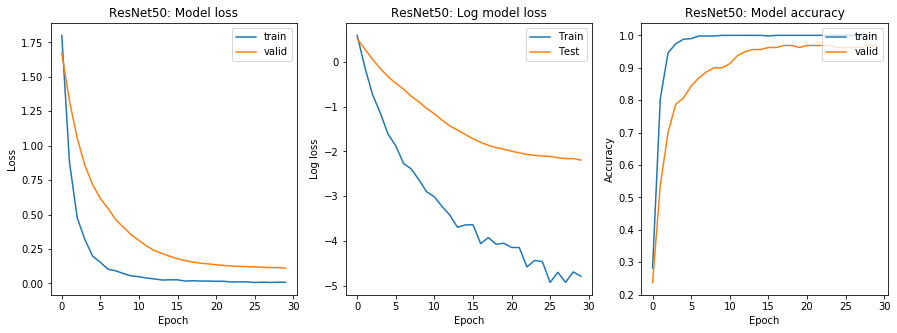

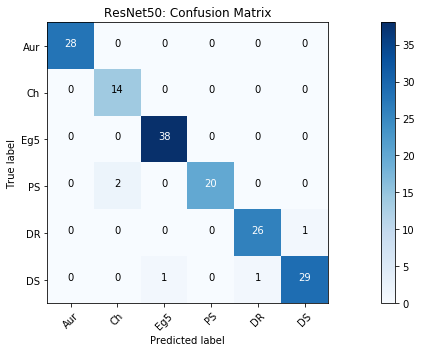


classification report for validation data:
              precision    recall  f1-score   support

           0      1.000     1.000     1.000        28
           1      0.875     1.000     0.933        14
           2      0.974     1.000     0.987        38
           3      1.000     0.909     0.952        22
           4      0.963     0.963     0.963        27
           5      0.967     0.935     0.951        31

    accuracy                          0.969       160
   macro avg      0.963     0.968     0.964       160
weighted avg      0.970     0.969     0.969       160



In [33]:
IMG_SIZE = (256, 256)
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.ResNet50(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

base_model.trainable = True

num_classes = 6
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
preds = layers.Dense(6, activation='softmax')(x)

ResNet50 = models.Model(inputs=base_model.input, outputs=preds)


lr = 0.00001
ResNet50.compile(optimizer=optimizers.Adam(lr=lr), 
               loss='categorical_crossentropy',
               metrics=['accuracy'])

batch_size = 32
n_epochs = 30

history = ResNet50.fit(X_train, Y_train,
                     batch_size=batch_size,
                     epochs=n_epochs,
                     validation_data=(X_valid, Y_valid),
                     verbose=2)

plot_history(history, 'ResNet50')
valid_evaluate(ResNet50, 'ResNet50')

## So...
for my run of the above model I a got a weighted avg f1-score of 0.988! I'm guessing you got something equally impressive. So of all the tricks we've learnt this week it seems that transfer learning shines out as a very good thing to do, expecially when our datasets are not particularly large, as is often the case in image cytometry.

I hope you enjoyed this week and are inspired to dive deeper into deep learning. Either way, that's it. Now you're free to run away and enjoy your weekend.

Cheers, - Phil

# THE END